# Opensearch
## Demonstration with Ifremer Opensearch Service for CCI products

Ifremer Opensearch service (https://opensearch.ifremer.fr/) allows to search and select Satellite and In Situ data over space and time criteria. It offers in particular search capabilities for various satellite products. No account is required.

This notebook shows how to query the Opensearch service in python, using the Atom/XML return format, without the need to install an extract package like ``eo-harvest``. This implies decoding and understanding the verbous XML stream returned by Opensearch service. 


## Main functions

Here are the main function to build the queries and decode the results. Examples of usage are provided in the following section.


In [120]:
import json
import urllib.request
from datetime import datetime
from typing import Tuple

import xml.etree.ElementTree as ET
import shapely.geometry as SG


# the service end-point URL
IFREMER_OPENSEARCH_URL = "https://opensearch.ifremer.fr/granules.atom"


def _format_opensearch_url(
        dataset_id: str,
        start: datetime,
        end: datetime,
        area= None,
        dac=None,
        protocol=None,
        page=0,
        count=100):
    """creates the opensearch query string from search arguments"""
    
    # build the search query URL
    search_url = IFREMER_OPENSEARCH_URL + \
        '?datasetId={}'.format(dataset_id) + \
        '&startPage={}&count={}'.format(page, count) + \
        '&timeStart={}Z&timeEnd={}Z'.format(start.isoformat(), end.isoformat())

    if area is not None:
        search_url += '&geoBox={}'.format(str(tuple(area)).replace(' ','').lstrip('(').strip(')'))
    
    if dac is not None:
        search_url += '&source={}'.format(dac)

    if protocol is not None:
        search_url += '&protocol={}'.format(protocol)

    return search_url


# Helper to parse coordinates from raw string to array of points
def parse_coordinates(raw_str):
    ret = []
    coords = raw_str.split()
    n = len(coords)
    for i in range(0, n, 2):
        ret.append([float(coords[i]), float(coords[i+1])])
    return ret


def decode_opensearch_result(contents):
    """format the search result as a list, merge duplicates"""
    # Parse XML as ElementTree elements
    root = ET.fromstring(contents)

    status = {}
    status['total_results'] = int(root.find('.{http://a9.com/-/spec/opensearch/1.1/}totalResults').text)
    status['start_index'] = int(root.find('.{http://a9.com/-/spec/opensearch/1.1/}startIndex').text)
    status['items_per_page'] = int(root.find('.{http://a9.com/-/spec/opensearch/1.1/}itemsPerPage').text)

    entries = []
    
    # Foreach Atom entry..
    for entry in root.findall('./{http://www.w3.org/2005/Atom}entry'):
        
        item = {}
        
        item['name'] = entry.find('{http://www.w3.org/2005/Atom}title').text
        # Parse the Geometry as shapely.geometry
        shapely = None
        complex_geometry = entry.find('{http://www.georss.org/georss/10}where')
        if complex_geometry is not None:
            multi_polygon = complex_geometry.find('./{http://www.opengis.net/gml}MultiPolygon')
            if multi_polygon is not None:
                polygons = []
                # Build complex MultiPolygon
                for gmlPosList in complex_geometry.findall(
                        './{http://www.opengis.net/gml}MultiPolygon/{http://www.opengis.net/gml}polygonMember/{http://www.opengis.net/gml}Polygon/{http://www.opengis.net/gml}outerBoundaryIs/{http://www.opengis.net/gml}LinearRing/{http://www.opengis.net/gml}posList'):
                    polygons.append(SG.Polygon(parse_coordinates(gmlPosList.text)))
                shapely = SG.MultiPolygon(polygons)
            else:
                # Build complex MultiLineString
                multi_curve = complex_geometry.find('./{http://www.opengis.net/gml}MultiCurve')
                if multi_curve is not None:
                    line_strings = []
                    for gmlPosList in complex_geometry.findall(
                            './{http://www.opengis.net/gml}MultiCurve/{http://www.opengis.net/gml}curveMember/{http://www.opengis.net/gml}LineString/{http://www.opengis.net/gml}posList'):
                        line_strings.append(SG.LineString(parse_coordinates(gmlPosList.text)))
                    shapely = SG.MultiLineString(line_strings)
                else:
                    raise ValueError('A geometry value was incorrect (1).')
        else:
            # Build simple Point
            geoPoint = entry.find('{http://www.georss.org/georss/10}point')
            if geoPoint is not None :
                point = geoPoint.text.split()
                shapely = SG.Point(float(point[0]), float(point[1]))
            else:
                # Build simple Polygon
                geoPolygon = entry.find('{http://www.georss.org/georss/10}polygon')
                if geoPolygon is not None :
                    shapely = SG.Polygon(parse_coordinates(geoPolygon.text))
                else:
                    # Build simple Line
                    geoLine = entry.find('{http://www.georss.org/georss/10}line')
                    if geoLine is not None :
                        shapely = SG.LineString(parse_coordinates(geoLine.text))
                    else:
                        raise ValueError('A geometry value was incorrect (2).')

        item['geometry'] = shapely
        
        dates = entry.find('{http://purl.org/dc/elements/1.1}date').text.split('/')
        import dateutil
        item['start'] = dateutil.parser.parse(dates[0])
        item['end'] = dateutil.parser.parse(dates[0])

        item['url'] = {}
        for link in entry.findall('./{http://www.w3.org/2005/Atom}link'):
            attr = link.attrib
            item['url'][attr.get(r'title')] = attr.get(r'href')
        
        entries.append(item)
        
    return status, entries,


def search(
        dataset_id: str,
        start: datetime,
        end: datetime = None,
        area: Tuple[float, float, float, float] = None,
        dac: str = None,
        protocol: str = None,
        trace: bool = False
    ):
    """The main search function. Queries data files from a given GHRSST collection.
    
    When the same data files are returned from different DACs, they are merged into a 
    single entry in the list of results, providing all the possible download URLs. 
    
    It is possible to request the results from a specific DAC only, or for a given download
    protocol (FTP, HTTP, ...).
    
    Args:
        dataset_id: the identifier of the collection, as found in GHRSST catalogue.
        start: the start date and time of the search temporal interval, as a python 
            datetime object.
        end: the end date and time of the search temporal interval, as a python 
            datetime object. By default, the current date and time is used.
        area: the boundaries of the search area, as a list [lon min, lat min, lon max, lat max]. 
            By default the whole world is selected.
        dac: the identifier of the DAC to query. By default all DACs are queried. Use this
            argument to limit the search to a specific DAC.
        protocol: the type of download link to be returned for each found data file. By
            default, all links are returned. Use this argument to include in the search results
            only FTP, HTTPS, etc links.
        trace: print some traces of the queries to opensearch service
    """
    results = []

    if end is None:
        end = datetime.now()

    last_page = False
    page = 0
    while not last_page:
        # format the opensearch query
        uri = _format_opensearch_url(
            dataset_id, start, end, area, dac=dac, protocol=protocol, page=page)
        
        # call the service
        response = urllib.request.urlopen(uri)
        status_code = response.getcode()
        if trace:
            print(f'Requesting page {page}: {uri}')
            print("HTTP STATUS CODE = " + str(status_code))
        
        # decode XML result
        status, entries = decode_opensearch_result(response.read())
        
        results.extend(entries)
        
        if status['total_results'] < (status['start_index']+1)*status['items_per_page']:
            last_page = True
        
        page += 1

    return results


### Simple search
Searching granule files for a dataset using time and space criteria. Some of the currently accessible CCI Sea State products include:

* L2P v3 for Jason-1 : `cciseastate_l2p_alt_jason_1`
* L2P v3 for Jason-2 : `cciseastate_l2p_alt_jason_2`
* L2P v3 for Jason-3 : `cciseastate_l2p_alt_jason_3`
* L2P v3 for Cryosat-2 : `cciseastate_l2p_alt_cryosat_2`
* L2P v3 for ENVISAT : `cciseastate_l2p_alt_envisat`
* L2P v3 for SARAL : `cciseastate_l2p_alt_saral`
* L2P v3 for Sentinel-3 A : `cciseastate_l2p_alt_sentinel_3a`


Let's search for instance L2P for Jason-3 dataset, whose id is `cciseastate_l2p_alt_jason_3`.

We can then simply use the search function defined above, providing also the time frame (as datetime python objects) and the area, as a tuple (lon min, lat min, lon max, lat max), of interest.

In [121]:
# identifier, as provided in GHRSST catalogue
datasetId = "cciseastate_l2p_alt_jason_3"

# area of interest (lon min, lat min, lon max, lat max)
area = (-180.0, -90.0, 180.0, 90.0)

# timeframe of interest
start = datetime(2020, 1, 1)
end = datetime(2020, 1, 2)

res = search(datasetId, start=start, end=end, area=area)

print(f'Number of files found: {len(res)}')


Number of files found: 27


## Inspecting the result

We get in ``res`` variable the list of granules, with their properties, that were returned by the query. A few operations can be done on these results.

### Display result footprints

It is possible to display the location of these found granules using ``cartopy`` and ``matplotlib`` packages:

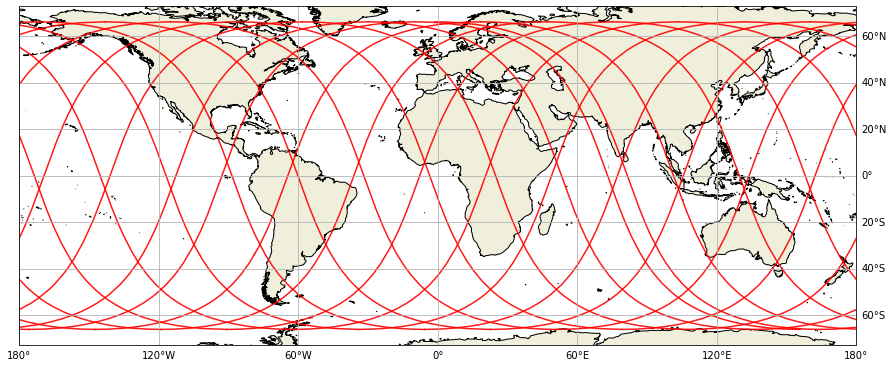

In [126]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
land_50m = cfeature.NaturalEarthFeature(
    'physical', 'land', '50m', edgecolor='face',
    facecolor=cfeature.COLORS['land'])
ax.add_feature(land_50m)
ax.coastlines('50m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.left_labels = False

for item in res:
    if isinstance(item['geometry'], LineString):
        ax.plot(*item['geometry'].coords.xy, color='r', alpha=0.9)
    elif isinstance(item['geometry'], MultiLineString):
        for geom in item['geometry'].geoms:
            ax.plot(*geom.coords.xy, color='r', alpha=0.9)

### Description of the returned granules

The properties of the returned granules can be inspected, just printing the returned granule objects. Note that different protocols (and therefore URLs) are available to actually download granules.

In [118]:
# display the details of the first granule in the returned list
print(res[0])

{'name': 'ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T034650-fv01.nc', 'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x7f32bad85d60>, 'start': datetime.datetime(2020, 1, 1, 3, 46, 50), 'end': datetime.datetime(2020, 1, 1, 3, 46, 50), 'url': {'DATARMOR GPFS': '/home/datawork-cersat-public/provider/cci_seastate/products/v3/data/satellite/altimeter/l2p/jason-3/2020/001/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T034650-fv01.nc', 'HTTPS': 'https://dap.ceda.ac.uk/neodc/esacci/sea_state/data/v3_release/altimeter/l2p/jason-3/v3.0/2020/01/01/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T034650-fv01.nc'}}


In [119]:
# print the name and URL (for local network access: 'DATARMOR GPFS') of all found granules
for c in res:
    print(c['name'])
    print('URL: ', c['url']['DATARMOR GPFS'])
    print()

ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T034650-fv01.nc
URL:  /home/datawork-cersat-public/provider/cci_seastate/products/v3/data/satellite/altimeter/l2p/jason-3/2020/001/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T034650-fv01.nc

ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T053915-fv01.nc
URL:  /home/datawork-cersat-public/provider/cci_seastate/products/v3/data/satellite/altimeter/l2p/jason-3/2020/001/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T053915-fv01.nc

ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T082754-fv01.nc
URL:  /home/datawork-cersat-public/provider/cci_seastate/products/v3/data/satellite/altimeter/l2p/jason-3/2020/001/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T082754-fv01.nc

ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T121246-fv01.nc
URL:  /home/datawork-cersat-public/provider/cci_seastate/products/v3/data/satellite/altimeter/l2p/jason-3/2020/001/ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T121246-fv01.nc

ESACCI-SEASTATE-L2P-SWH-Jason-3-20200101T175003-fv01.nc
URL:  /home/datawork-cersat-publ